In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Exploratory Data Exploration

In [2]:
credit_data=pd.read_csv("credit_risk_dataset.csv")

In [3]:
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Target Variable : loan_status 
0 - non_default

1 - default
- **person_age (int)**: Age of the individual applying for the loan.
- **person_income (int)**: Annual income of the individual.
- **person_home_ownership (category)**: Type of home ownership of the individual.
  - **rent**: The individual is currently renting a property.
  - **mortgage**: The individual has a mortgage on the property they own.
  - **own**: The individual owns their home outright.
  - **other**: Other categories of home ownership that may be specific to the dataset.
- **person_emp_length (int)**: Employment length of the individual in years.
- **loan_intent (category)**: The intent behind the loan application.
- **loan_grade (category)**: The grade assigned to the loan based on the creditworthiness of the borrower.
  - **A**: The borrower has a high creditworthiness, indicating low risk.
  - **B**: The borrower is relatively low-risk, but not as creditworthy as Grade A.
  - **C**: The borrower's creditworthiness is moderate.
  - **D**: The borrower is considered to have higher risk compared to previous grades.
  - **E**: The borrower's creditworthiness is lower, indicating a higher risk.
  - **F**: The borrower poses a significant credit risk.
  - **G**: The borrower's creditworthiness is the lowest, signifying the highest risk.
- **loan_amnt (int)**: The loan amount requested by the individual.
- **loan_int_rate (float)**: The interest rate associated with the loan.
- **loan_status (binary)**: Loan status, where 0 indicates non-default and 1 indicates default.
  - **0**: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
  - **1**: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
- **loan_percent_income (float)**: The percentage of income represented by the loan amount (debt-to-income ratio) assess ability to handle loan repayments. .
- **cb_person_default_on_file (binary)**: Historical default of the individual as per credit bureau records.
  - **Y**: The individual has a history of defaults on their credit file.
  - **N**: The individual does not have any history of defaults.
- **cb_person_cred_hist_length (int)**: The length of credit history for the individual.


In [4]:
credit_data['cb_person_default_on_file']=credit_data['cb_person_default_on_file'].map({'Y':1,'N':0})

In [5]:
categorical_cols=['person_home_ownership','loan_intent','loan_grade']
numeric_cols=['person_age','person_income','person_emp_length','loan_amnt',
              'loan_int_rate','loan_status','loan_percent_income','cb_person_default_on_file','cb_person_cred_hist_length']

credit_data[categorical_cols]=credit_data[categorical_cols].astype('category')

In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32581 non-null  int64   
 1   person_income               32581 non-null  int64   
 2   person_home_ownership       32581 non-null  category
 3   person_emp_length           31686 non-null  float64 
 4   loan_intent                 32581 non-null  category
 5   loan_grade                  32581 non-null  category
 6   loan_amnt                   32581 non-null  int64   
 7   loan_int_rate               29465 non-null  float64 
 8   loan_status                 32581 non-null  int64   
 9   loan_percent_income         32581 non-null  float64 
 10  cb_person_default_on_file   32581 non-null  int64   
 11  cb_person_cred_hist_length  32581 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 2.3 MB


In [7]:
credit_data.describe(include="category")

,person_home_ownership,loan_intent,loan_grade
count,32581,32581,32581
unique,4,6,7
top,RENT,EDUCATION,A
freq,16446,6453,10777


In [8]:
credit_data.describe(include="number")

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,0.176330,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,0.381106,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,0.000000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


In [9]:
# Max 144 Age can not be possible, therefore checking for irregular value in the dataset

In [10]:
credit_data[credit_data['person_age']>100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,0,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,0,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,0,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,0,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,0,25


In [11]:
(credit_data['person_age'] > 100).sum()

np.int64(5)

In [12]:
# dropping them
credit_data=credit_data[credit_data['person_age']<=100]

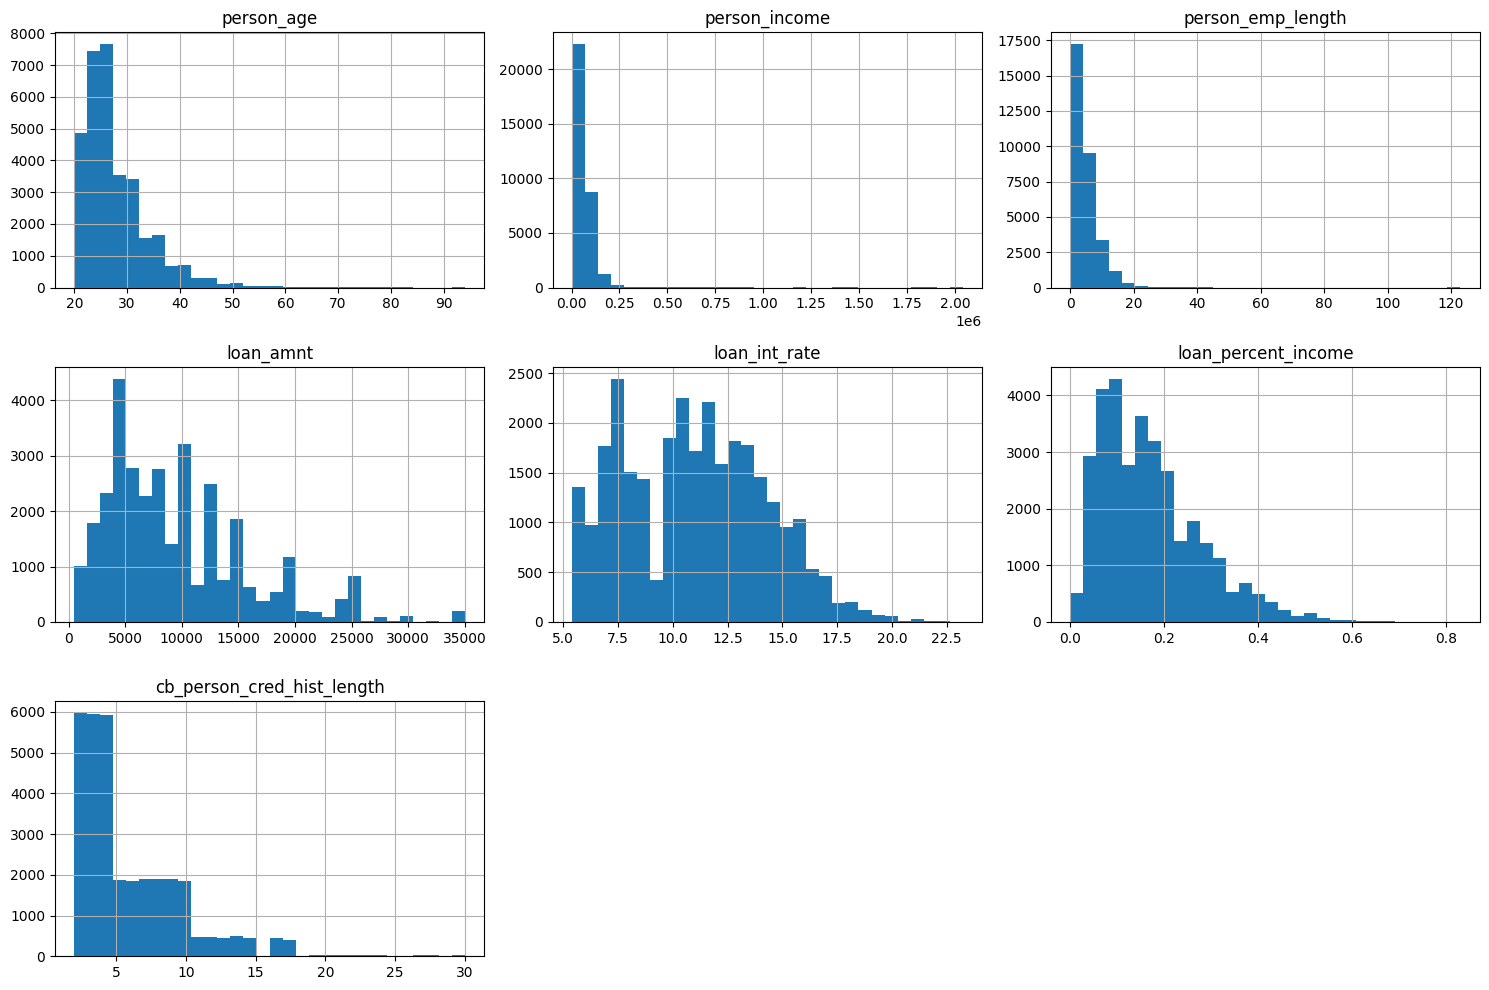

In [13]:
numerical_cols = ['person_age', 'person_income', 'person_emp_length',
                  'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                  'cb_person_cred_hist_length']

credit_data[numerical_cols].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

## Target variable has class imbalance, have to handle this before modeling

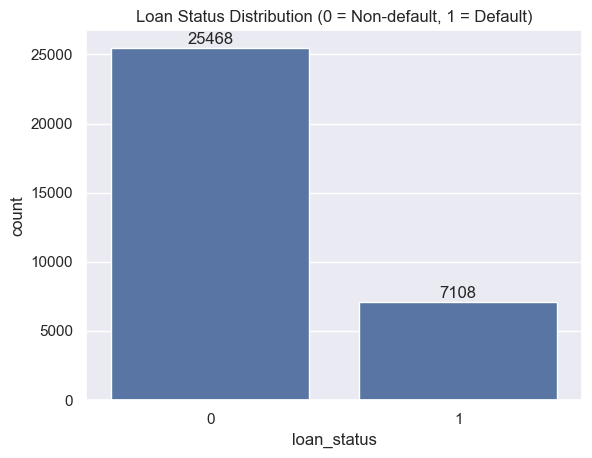

In [14]:
sns.set()
ax = sns.countplot(x='loan_status', data=credit_data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 50, f'{int(height)}',ha='center', va='bottom')
plt.title('Loan Status Distribution (0 = Non-default, 1 = Default)')
plt.savefig("Loan_dist.jpeg")
plt.show()

## Target variable has class imbalance, have to handle this before modeling

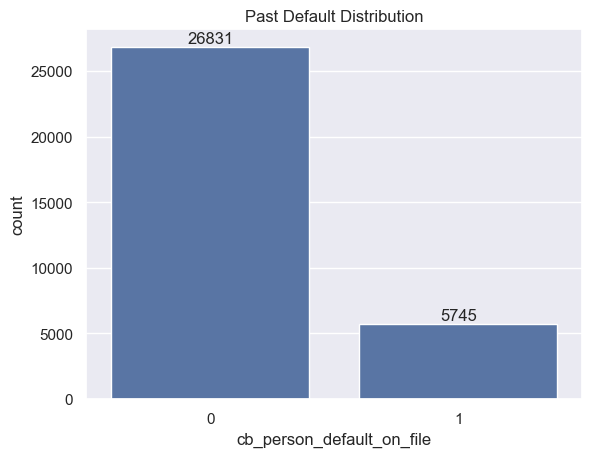

In [15]:
ax=sns.countplot(x='cb_person_default_on_file', data=credit_data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 50, f'{int(height)}',ha='center', va='bottom')
plt.title("Past Default Distribution")
plt.show()

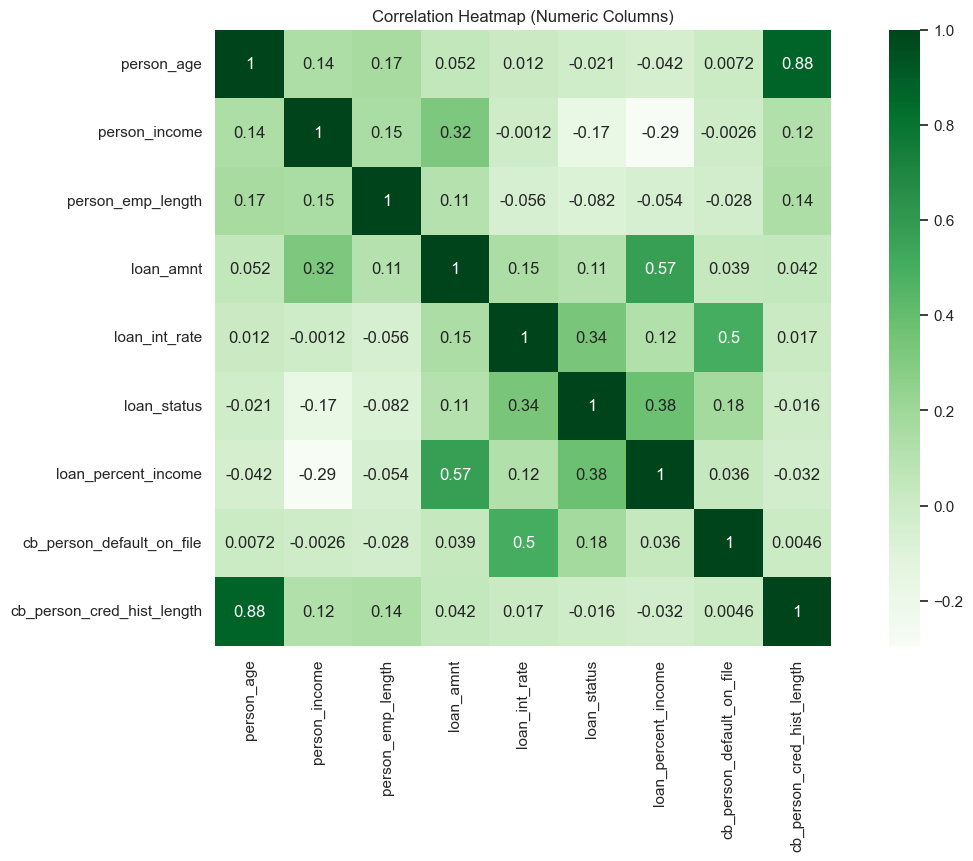

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap(credit_data[['person_age','person_income','person_emp_length','loan_amnt',
              'loan_int_rate','loan_status','loan_percent_income','cb_person_default_on_file','cb_person_cred_hist_length']].corr(),
            square = True, annot = True,cmap='Greens' )
plt.title('Correlation Heatmap (Numeric Columns)')
plt.savefig("heat.jpeg")
plt.show()

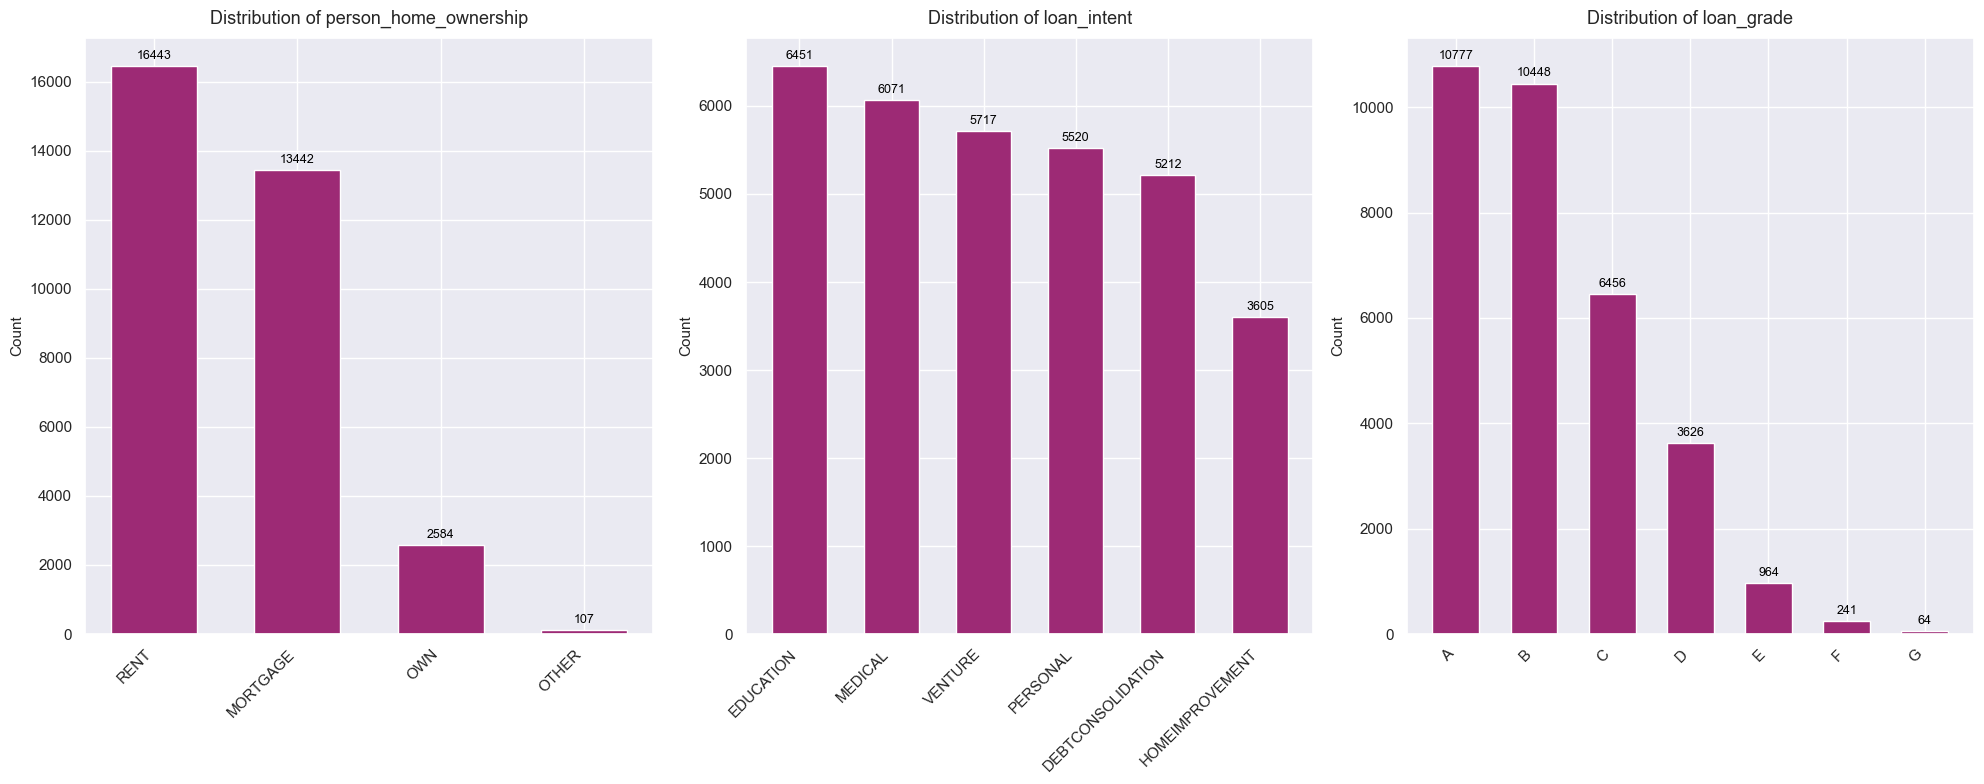

In [17]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']

color_palette = ['#9d2a75']  

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes = axes.flatten()


for i, col in enumerate(categorical_cols):
    ax = axes[i]

    value_counts = credit_data[col].value_counts()

    
    bars = ax.bar(value_counts.index, value_counts.values, color=color_palette[0], width=0.6)


    ax.set_title(f'Distribution of {col}', fontsize=13, pad=10)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_xlabel('')
    ax.set_xticks(range(len(value_counts.index)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')


    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9, color='black')
        
plt.tight_layout()
plt.show()

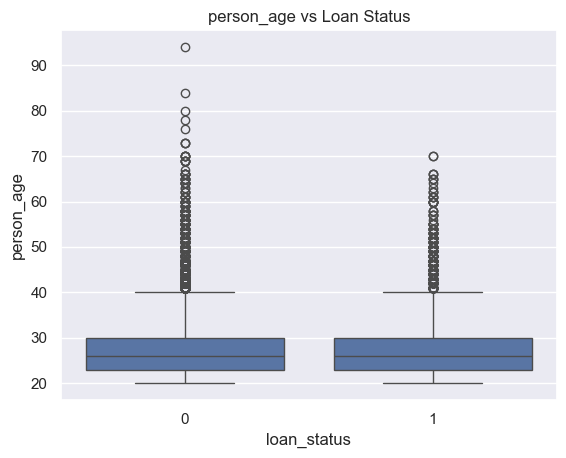

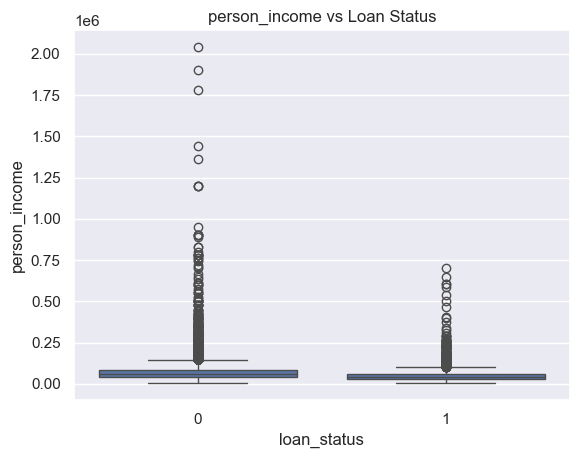

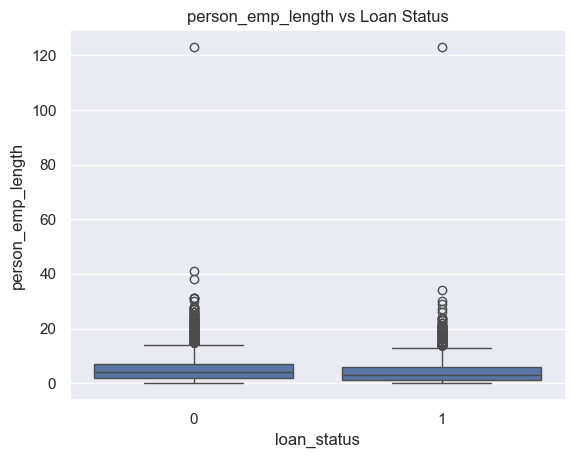

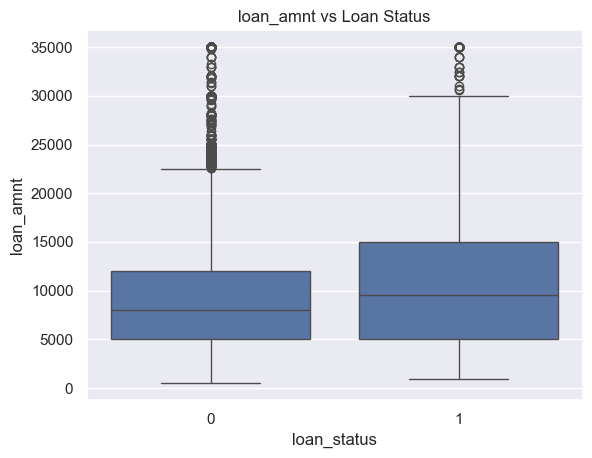

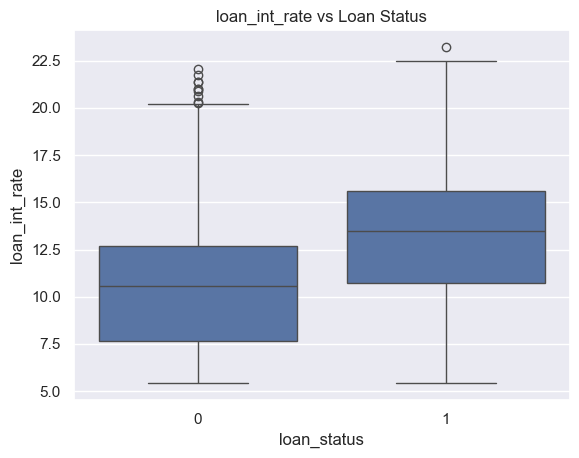

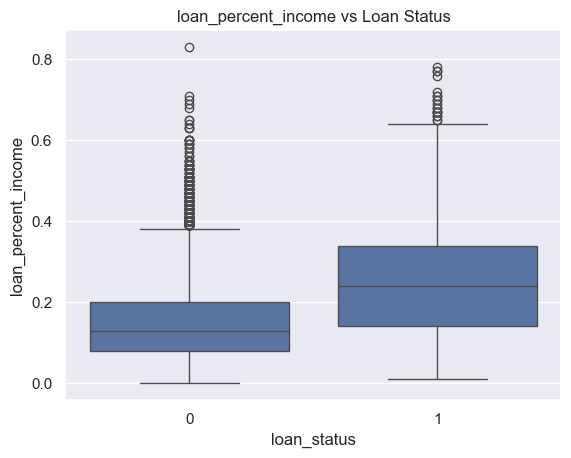

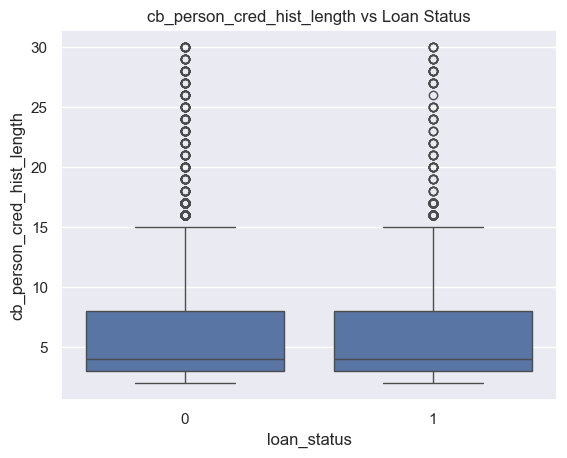

In [18]:
for col in numerical_cols:
    sns.boxplot(x='loan_status', y=col, data=credit_data)
    plt.title(f'{col} vs Loan Status')
    plt.show()

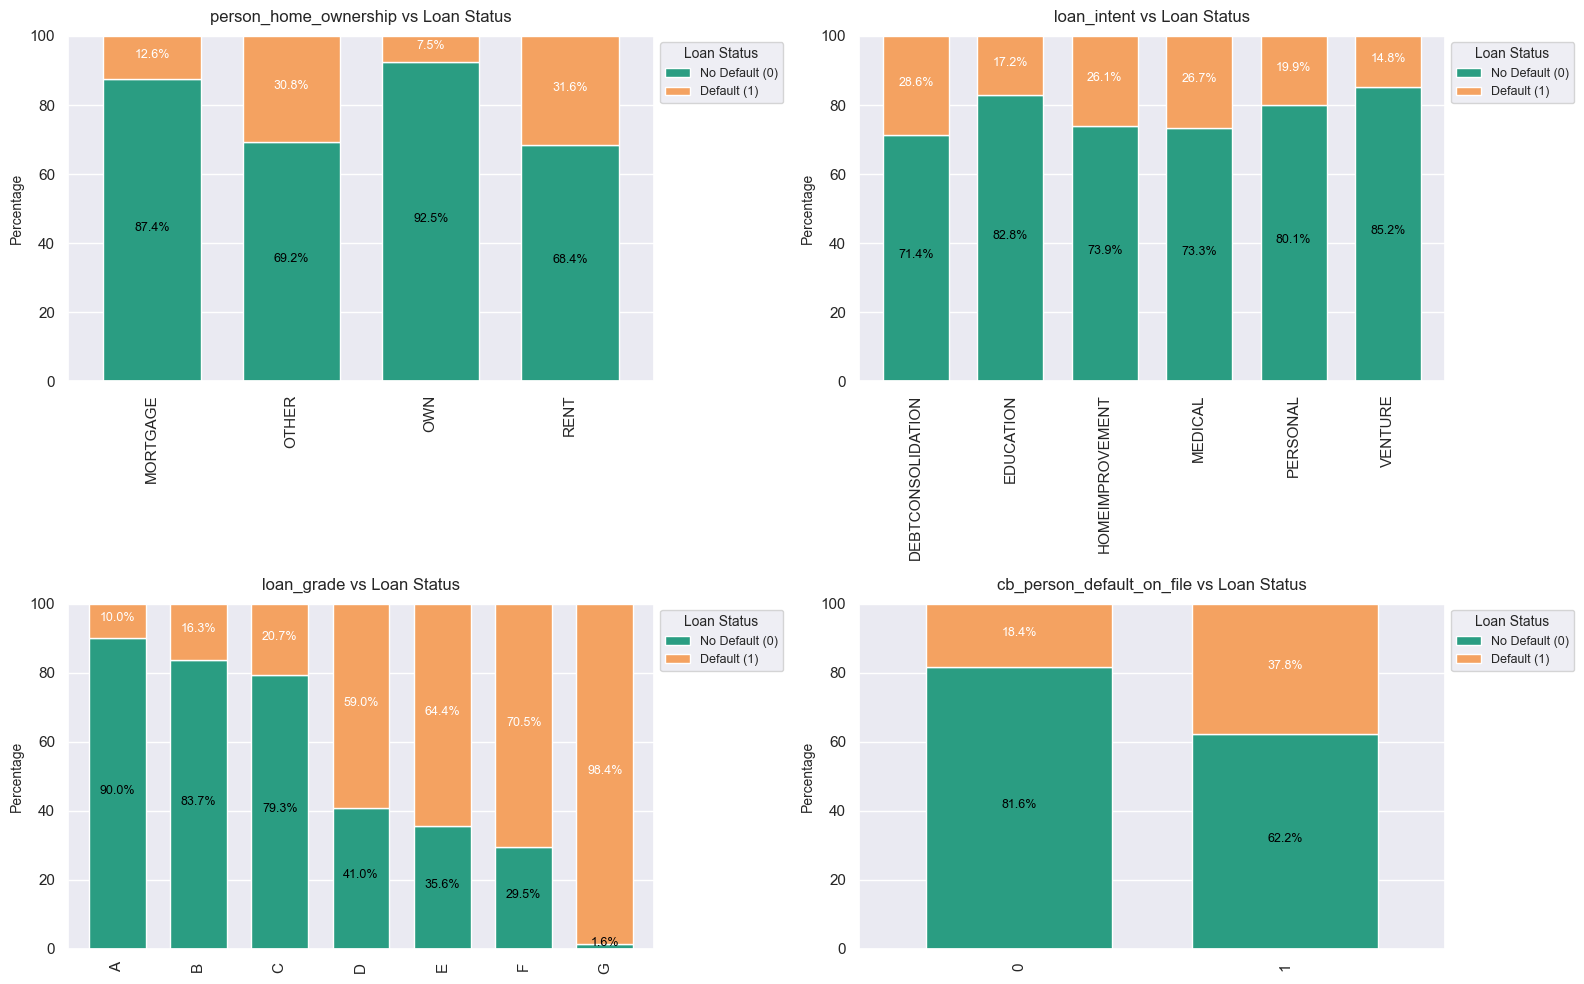

In [19]:
feature_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
target_col = 'loan_status'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors = ['#2a9d82', '#F4A261'] 

for i, col in enumerate(feature_cols):
    ax = axes[i]

    count_df = pd.crosstab(credit_data[col], credit_data[target_col])
    
    percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

    bars = percent_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

    ax.set_title(f'{col} vs Loan Status', fontsize=12, pad=10)
    ax.set_ylabel("Percentage", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylim(0, 100) 

    for container in ax.containers:
        values = container.datavalues
        labels = [f'{v:.1f}%' if v > 0 else '' for v in values]
        ax.bar_label(container, labels=labels,
                     label_type='center',
                     color='white' if container.get_label() == '1' else 'black',
                     fontsize=9,
                     padding=2)

    ax.legend(title="Loan Status", labels=['No Default (0)', 'Default (1)'],
              bbox_to_anchor=(1, 1), title_fontsize=10, fontsize=9)

plt.tight_layout()
plt.savefig("categorical_percentage_vs_default.png", dpi=300, bbox_inches='tight')
plt.savefig("defaultatt.jpeg")
plt.show()


In [20]:
df=credit_data[(credit_data['loan_intent'] == 'EDUCATION') & (credit_data['person_home_ownership'] == 'RENT')]

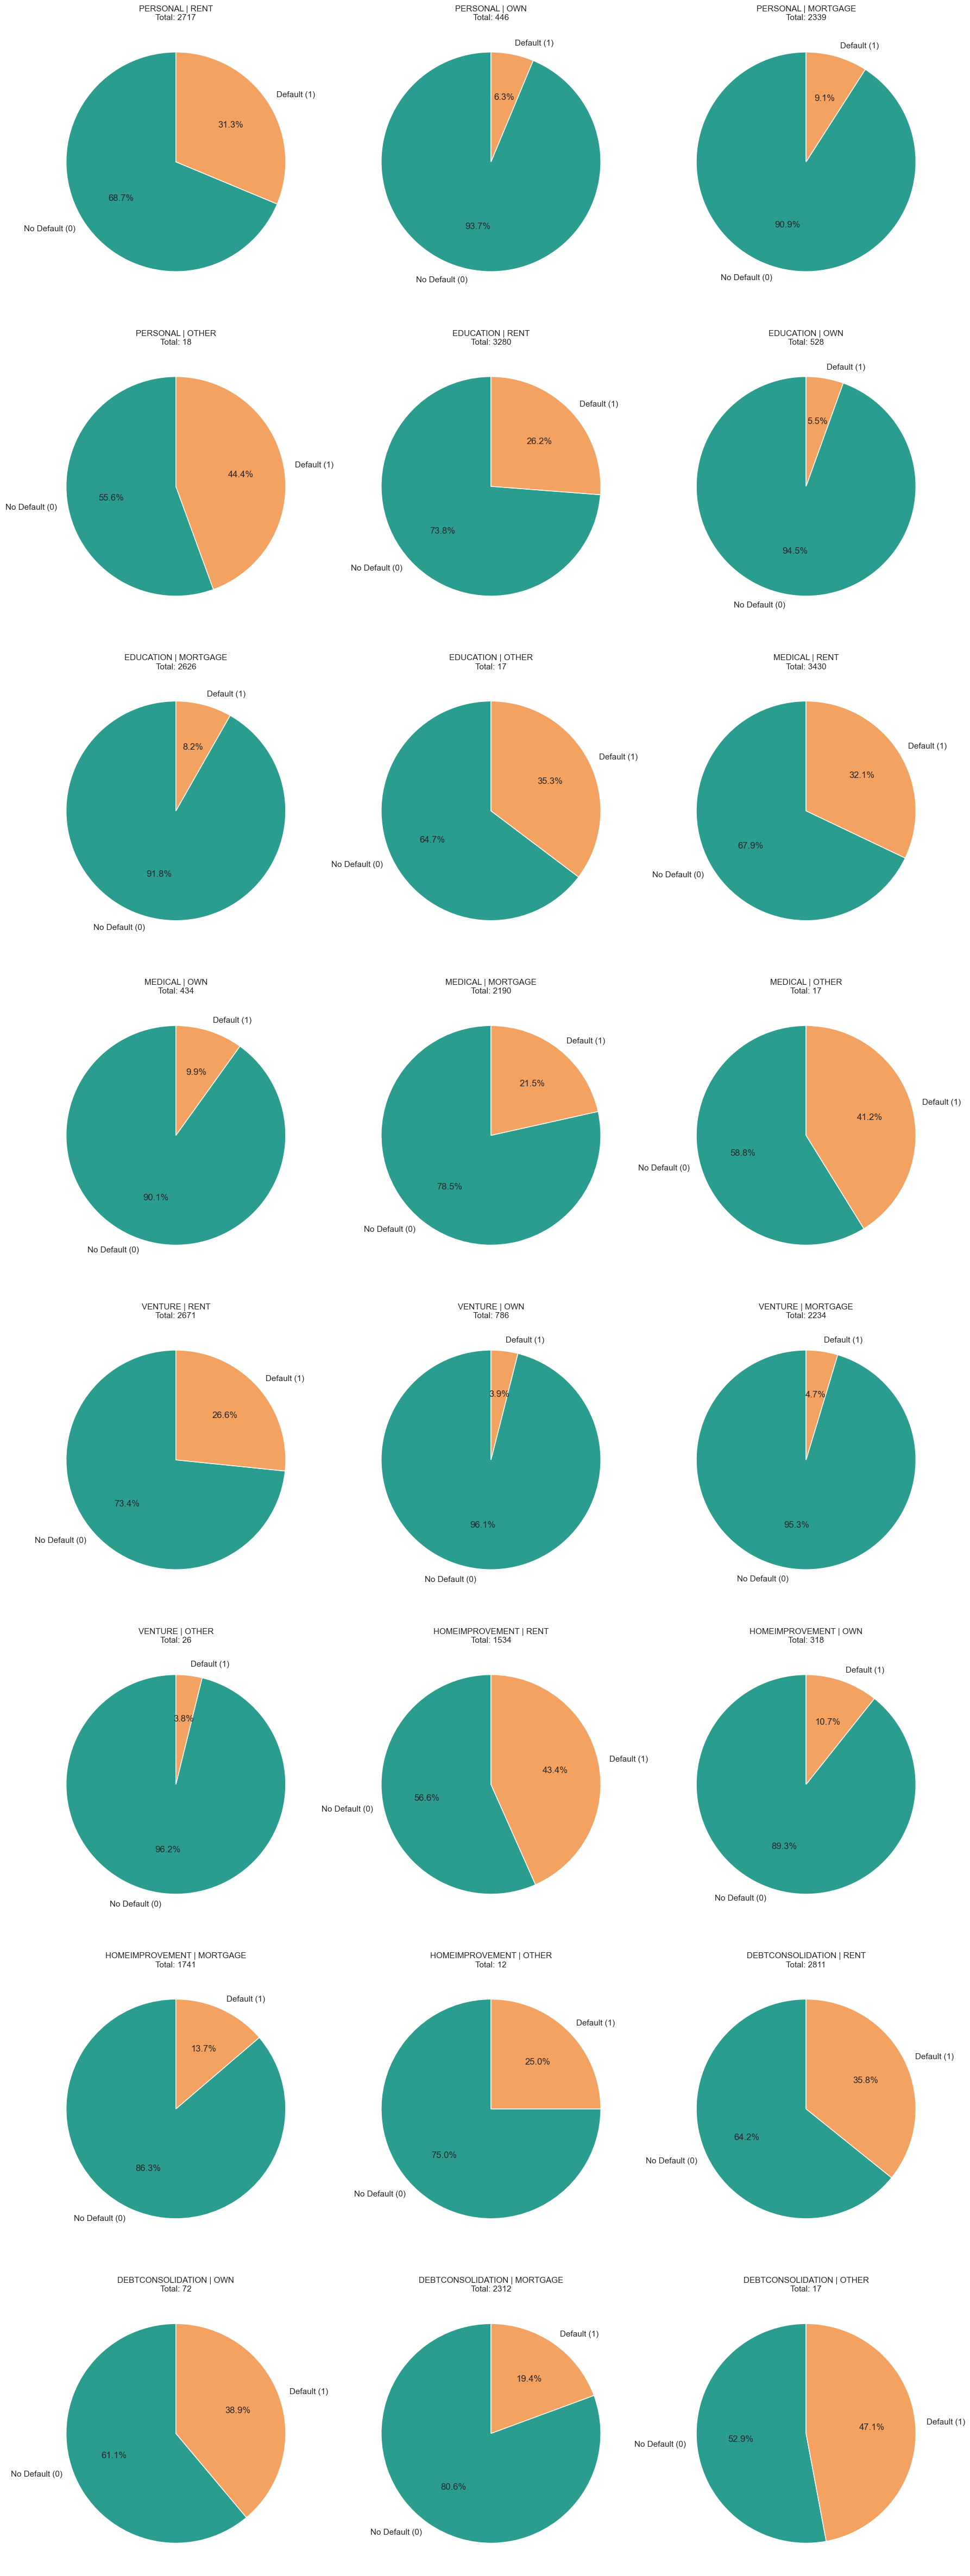

In [21]:
home_types = credit_data['person_home_ownership'].unique()
loan_types = credit_data['loan_intent'].unique()
target = 'loan_status'


total_charts = len(home_types) * len(loan_types)
cols = 3
rows = (total_charts + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

colors = ['#2A9D8F', '#F4A261']
labels = ['No Default (0)', 'Default (1)']

chart_index = 0

for loan in loan_types:
    for home in home_types:
        subset = credit_data[
            (credit_data['loan_intent'] == loan) &
            (credit_data['person_home_ownership'] == home)
        ]
        
        if subset.empty:
            continue
        
        counts = subset[target].value_counts().sort_index()
        
        counts = counts.reindex([0, 1], fill_value=0)
        
        ax = axes[chart_index]
        ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title(f'{loan} | {home}\nTotal: {counts.sum()}', fontsize=11)
        chart_index += 1


for i in range(chart_index, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("pie.jpeg")
plt.show()


In [22]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32576 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32576 non-null  int64   
 1   person_income               32576 non-null  int64   
 2   person_home_ownership       32576 non-null  category
 3   person_emp_length           31681 non-null  float64 
 4   loan_intent                 32576 non-null  category
 5   loan_grade                  32576 non-null  category
 6   loan_amnt                   32576 non-null  int64   
 7   loan_int_rate               29461 non-null  float64 
 8   loan_status                 32576 non-null  int64   
 9   loan_percent_income         32576 non-null  float64 
 10  cb_person_default_on_file   32576 non-null  int64   
 11  cb_person_cred_hist_length  32576 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 2.6 MB


In [23]:
credit_data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

We can see that we have missing values in the dataset

In [24]:
credit_data[credit_data['loan_int_rate'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,0,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,1,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,0,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,1,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,1,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,1,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,0,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,0,23


In [25]:
credit_data[credit_data['person_emp_length'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,0,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,0,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,0,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,0,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32285,38,12000,OWN,NaN,EDUCATION,A,4800,7.29,1,0.40,0,12
32328,51,18408,RENT,NaN,PERSONAL,C,1000,14.65,1,0.05,1,20
32360,70,39996,RENT,NaN,MEDICAL,C,3600,15.23,0,0.09,1,19
32453,56,32400,RENT,NaN,MEDICAL,A,8575,7.51,0,0.26,0,18


In [26]:
credit_data[credit_data['person_emp_length'].isnull() & credit_data['loan_int_rate'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,0,3
1388,22,26400,MORTGAGE,NaN,HOMEIMPROVEMENT,A,1550,NaN,1,0.06,0,2
1395,22,26400,MORTGAGE,NaN,PERSONAL,B,1000,NaN,1,0.04,0,2
1651,23,28296,MORTGAGE,NaN,PERSONAL,B,7000,NaN,0,0.25,0,4
1698,23,28800,MORTGAGE,NaN,MEDICAL,A,10625,NaN,0,0.37,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
30460,39,23000,RENT,NaN,MEDICAL,A,7200,NaN,1,0.31,0,17
30523,36,57600,OWN,NaN,EDUCATION,A,4000,NaN,0,0.07,0,15
31573,40,108000,OWN,NaN,PERSONAL,A,3500,NaN,0,0.03,0,15
31926,40,8628,OWN,NaN,DEBTCONSOLIDATION,A,2500,NaN,1,0.29,0,17


In [27]:
credit_data['person_emp_length'].median()

np.float64(4.0)

In [28]:
credit_data['loan_int_rate'].median()

np.float64(10.99)

In [29]:
credit_data[['loan_int_rate','person_emp_length']].describe()

,loan_int_rate,person_emp_length
count,29461.000000,31681.000000
mean,11.011547,4.789527
std,3.240623,4.142706
min,5.420000,0.000000
25%,7.900000,2.000000
50%,10.990000,4.000000
75%,13.470000,7.000000
max,23.220000,123.000000


## Using median imputation for both the variables

In [30]:
median_int_rate = credit_data['loan_int_rate'].median()
credit_data['loan_int_rate'] = credit_data['loan_int_rate'].fillna(median_int_rate)

median_emp_length = credit_data['person_emp_length'].median()
credit_data['person_emp_length'] = credit_data['person_emp_length'].fillna(median_emp_length)

In [31]:
credit_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [32]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']
credit_data['cb_person_default_on_file']=credit_data['cb_person_default_on_file'].astype(bool)

In [33]:
credit_data = pd.get_dummies(credit_data, columns=categorical_features, drop_first=True,dtype=int)

In [34]:
credit_data

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,16.02,1,0.59,True,3,0,...,0,0,1,0,0,0,1,0,0,0
1,21,9600,5.0,1000,11.14,0,0.10,False,2,0,...,0,0,0,0,1,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,False,3,0,...,0,1,0,0,0,1,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,False,2,0,...,0,1,0,0,0,1,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,True,4,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,False,30,0,...,0,0,1,0,0,1,0,0,0,0
32577,54,120000,4.0,17625,7.49,0,0.15,False,19,0,...,0,0,1,0,0,0,0,0,0,0
32578,65,76000,3.0,35000,10.99,1,0.46,False,28,0,...,1,0,0,0,1,0,0,0,0,0
32579,56,150000,5.0,15000,11.48,0,0.10,False,26,0,...,0,0,1,0,1,0,0,0,0,0


In [35]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32576 entries, 0 to 32580
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32576 non-null  int64  
 1   person_income                32576 non-null  int64  
 2   person_emp_length            32576 non-null  float64
 3   loan_amnt                    32576 non-null  int64  
 4   loan_int_rate                32576 non-null  float64
 5   loan_status                  32576 non-null  int64  
 6   loan_percent_income          32576 non-null  float64
 7   cb_person_default_on_file    32576 non-null  bool   
 8   cb_person_cred_hist_length   32576 non-null  int64  
 9   person_home_ownership_OTHER  32576 non-null  int64  
 10  person_home_ownership_OWN    32576 non-null  int64  
 11  person_home_ownership_RENT   32576 non-null  int64  
 12  loan_intent_EDUCATION        32576 non-null  int64  
 13  loan_intent_HOMEIMPRO

In [36]:
X = credit_data.drop('loan_status', axis=1)
y = credit_data['loan_status']

print("Original Data Shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# This prevents data leakage from the test set into the resampler.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

print("\nAfter Initial Split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# from imblearn.over_sampling import ADASYN
# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
resamp = RandomOverSampler()
X_train_resampled, y_train_resampled = resamp.fit_resample(X_train, y_train)

# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 2: Apply the resampling technique ONLY to the training data
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print("\nAfter Resampling (on training data only):")
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

numeric_cols = ['person_age', 'person_income', 'person_emp_length',
                'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

scaler = StandardScaler()

# Fit the scaler ONLY on the resampled training data and transform it
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])

# Transform the test data using the scaler FIT on the training data.
# DO NOT refit the scaler on the test data.
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

Original Data Shapes:
X shape: (32576, 22)
y shape: (32576,)

After Initial Split:
X_train shape: (22803, 22)
y_train shape: (22803,)
X_test shape: (9773, 22)
y_test shape: (9773,)

After Resampling (on training data only):
X_train_resampled shape: (35654, 22)
y_train_resampled shape: (35654,)


In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22803, 22)
(9773, 22)
(22803,)
(9773,)


In [38]:
logreg = LogisticRegression(
    max_iter=1000,
    random_state=11
)
logreg.fit(X_train_resampled, y_train_resampled)


y_probs = logreg.predict_proba(X_test)[:, 1]

custom_threshold = 0.38
y_pred = (y_probs >= custom_threshold).astype(int)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))  # ROC still uses probs
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.72      0.82      7641
           1       0.46      0.84      0.59      2132

    accuracy                           0.75      9773
   macro avg       0.70      0.78      0.70      9773
weighted avg       0.84      0.75      0.77      9773

ROC-AUC: 0.8705362941551857
Accuracy: 0.7481837716156758
Confusion Matrix:
 [[5527 2114]
 [ 347 1785]]


If the cost of missing a defaulter is much higher than falsely flagging a safe customer, this is a great improvement.

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
print("PR AUC:", average_precision_score(y_test, y_pred))

PR AUC: 0.4188035023928143


In [40]:
X_train.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G'],
      dtype='object')

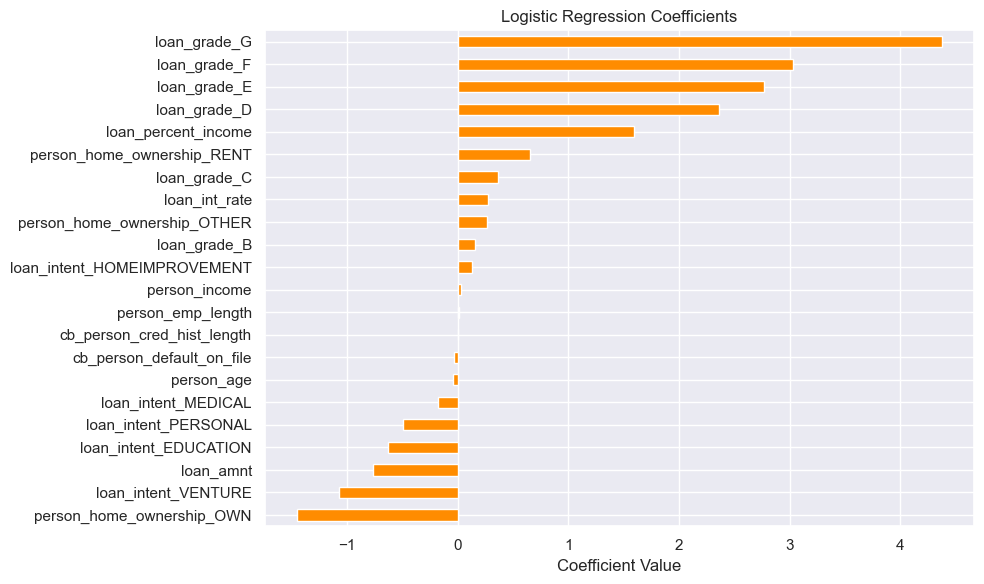

In [41]:
coefficients = pd.Series(logreg.coef_[0], index=X_train_resampled.columns)
coefficients.sort_values().plot(kind='barh', figsize=(10, 6), color='darkorange')
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.savefig("lr.jpg")
plt.tight_layout()
plt.show()


## loan_percent_income, loan_intent_rent, loan_intent_other are most strongly associated with defaults,
## Higher income and longer credit history significantly reduce default likelihood.

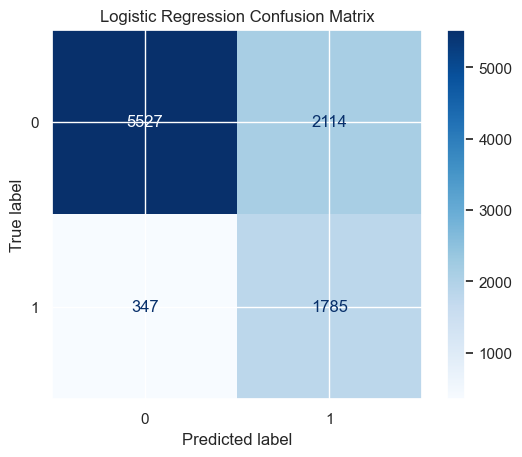

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.savefig("lr_m.jpg")
plt.show()

In [43]:
train_probs = logreg.predict_proba(X_train_resampled)[:, 1]
test_probs = logreg.predict_proba(X_test)[:, 1]

print(f"Train ROC-AUC: {roc_auc_score(y_train_resampled, train_probs):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, test_probs):.4f}")

Train ROC-AUC: 0.8702
Test ROC-AUC: 0.8705


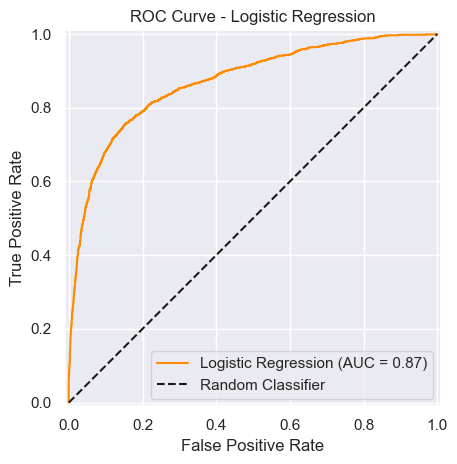

In [44]:
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve for Logistic Regression
RocCurveDisplay.from_predictions(y_test, test_probs, name='Logistic Regression', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Diagonal line for reference
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("lr_roc_curve.jpg")
plt.show()


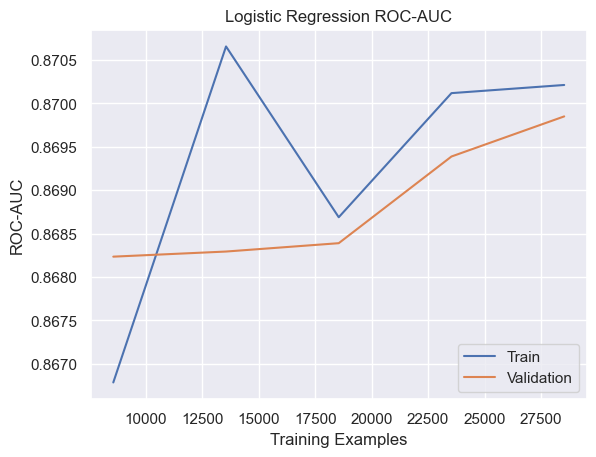

In [45]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    logreg, X_train_resampled, y_train_resampled,
    cv=cv, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.3, 1.0, 5)
)


plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.title("Logistic Regression ROC-AUC")
plt.legend()
plt.savefig("learning_curve_lr.png", dpi=300, bbox_inches='tight')
plt.show()




“The learning curve is based on 5-fold Stratified Cross-Validation using AUC as the scoring metric, evaluated on the resampled training data to reflect model behavior under class balance correction.”

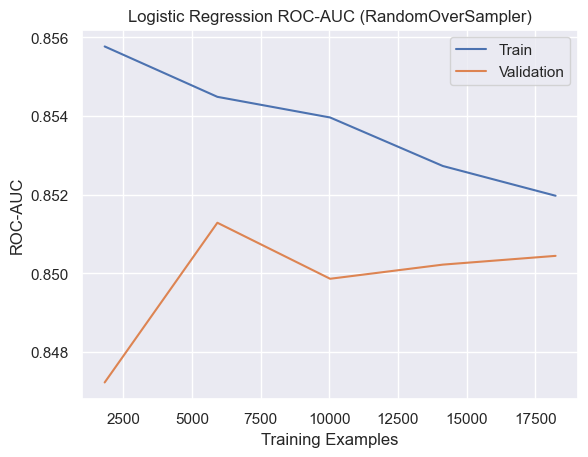

In [46]:
logreg_pipeline = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=11))
])

# Run the learning curve on the pipeline with the original imbalanced data
train_sizes, train_scores, test_scores = learning_curve(
    logreg_pipeline, 
    X_train,  # Original training data
    y_train,  # Original labels
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc', 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.title("Logistic Regression ROC-AUC (RandomOverSampler)")
plt.legend()
plt.savefig("learning_curve_lr_randomoversampler.png", dpi=300, bbox_inches='tight')
plt.show()


In [47]:
rf = RandomForestClassifier(
    n_estimators=200,
    # max_depth=10,        
    min_samples_leaf=1,   
    random_state=11
)
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for class 1
y_probs = rf.predict_proba(X_test)[:, 1]

custom_threshold = 0.38
y_pred = (y_probs >= custom_threshold).astype(int)


print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7641
           1       0.83      0.76      0.79      2132

    accuracy                           0.91      9773
   macro avg       0.88      0.86      0.87      9773
weighted avg       0.91      0.91      0.91      9773

ROC-AUC: 0.9304487148794655
Accuracy: 0.9129233602783178

Confusion Matrix: [[7297  344]
 [ 507 1625]]


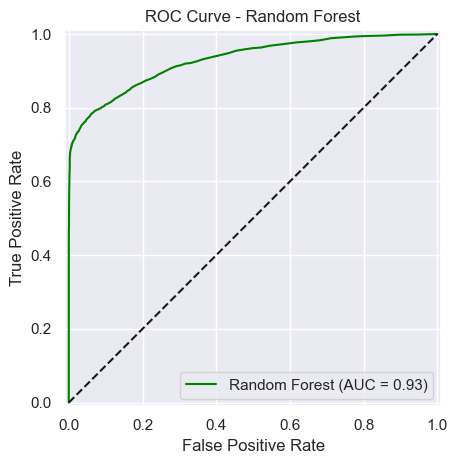

In [48]:
RocCurveDisplay.from_predictions(y_test, y_probs, name='Random Forest', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("rf_roc_curve.jpg")
plt.show()


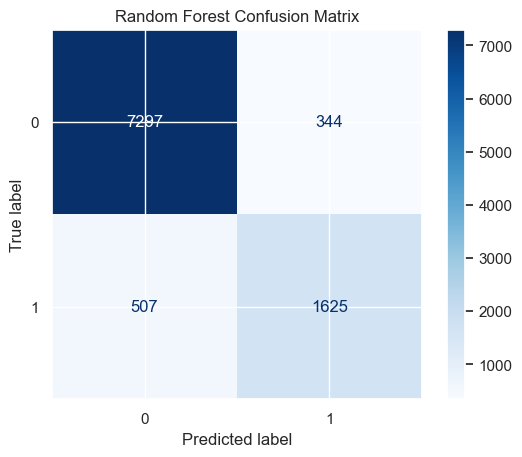

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.savefig("rf_m.jpg")
plt.show()

In [50]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

CV ROC-AUC: 0.930 ± 0.002


In [51]:
train_probs = rf.predict_proba(X_train_resampled)[:, 1]
test_probs = rf.predict_proba(X_test)[:, 1]

print(f"Train ROC-AUC: {roc_auc_score(y_train_resampled, train_probs):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, test_probs):.4f}")

Train ROC-AUC: 1.0000
Test ROC-AUC: 0.9304


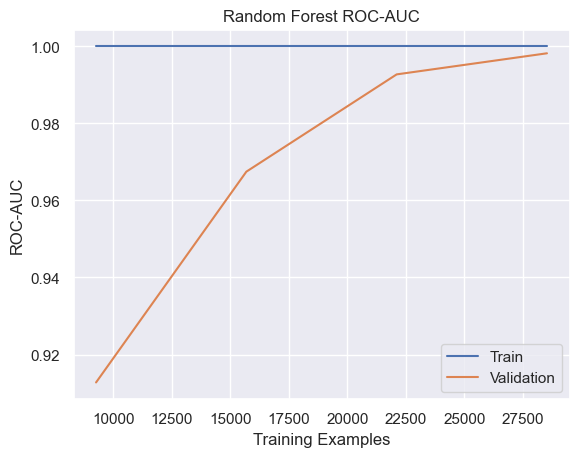

In [52]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train_resampled, y_train_resampled, cv=5,
    scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.title("Random Forest ROC-AUC")
plt.legend()
plt.savefig("learning_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [53]:
depths = [est.tree_.max_depth for est in rf.estimators_[:5]]
print(f"Tree depths: {depths}")

Tree depths: [29, 30, 32, 32, 35]


In [54]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

feature_importance_df.head(10)

,Feature,Importance
0,loan_percent_income,0.194400
1,person_income,0.176241
2,loan_int_rate,0.138263
3,loan_amnt,0.083682
4,loan_grade_D,0.061753
5,person_emp_length,0.054923
6,person_home_ownership_RENT,0.054233
7,person_age,0.050895
8,cb_person_cred_hist_length,0.040085
9,person_home_ownership_OWN,0.017414


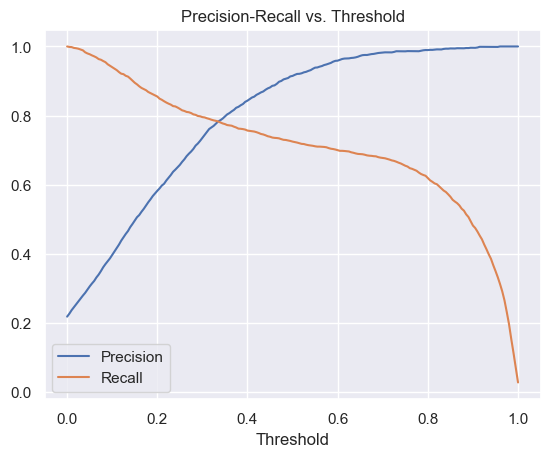

In [55]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title("Precision-Recall vs. Threshold")
plt.show()
